In [1]:
import keras
keras.__version__

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Práctica 7.4. Redes generativas adversarias

Las Redes Generativas Adversarias (GANs) fueron desarrolladas por Goodfellow et al en 2014 como una alternativa a las VAEs para aprender espacios latentes de imágenes. Estas son capaces de generar imágenes sintéticas muy realistas forzando a que no sea capaz de determinar si la imagen generada es real o no. 

Intuitivamente podemos pensar en un falsificador intentando crear un Picasso y enseñando su falsificación a un experto en arte. Este experto hará una valoración de cada falsificación que prepare. Con el tiempo el falsificador irá mejorando su falsificación, imitando mejor y mejor el estilo de Picasso hasta que el experto sea incapaz de determinar que se trata de una falsificación.

Esto es exactamente lo que hacen las GANs: la red falsifica y otra red hará de experta.
 - La red generadora (falsificador) toma como entrada una vector aleatorio (un punto aleatorio del espacio latente) y la decodifica a una imagen sintética.
 - La red adversaria (experta) tomará como entrada una imagen (que podrá ser real o sintética) y determinará si ésta es real o fue creada por la red generadora.
 
El hecho de entrenadar la red generadora para engañar a la red adversaria hará que la red generadora vaya generando imágenes cada vez más realistas. Mientras tanto, la red adversaria se va adaptando a las mejoras de la red generadora. Cuando el entrenamiento converge, el generador será capa de decodificar cualquier vector en una imagen sintética y realista. A diferencia de la VAEs, el espacio latente genenerado no tendrá ningun estructura útil ni será continuo.

<img src='img/gan.png' width=70% />

Hay que destacar que al entrenar una GAN el proceso de optimización no es fijo. En los ejemplos vistos hasta ahor,  siempre se tenía una superfice de error fija, pero con las GAN en cada iteración se modifica la superficie de error un poco. Es un sistema dinámico en el que el sistema de optimización no buscará un mínimo, sino un equilibrio entre dos fuerzas. Por esta razón, las GANs son especialmente difíciles de entrenar. Conseguir que una GAN funcione requiere de una cuidadosa optimización de los parámetros y de la arquitectura de las redes.


## 1. Un boceto de la implementación

Vamos a ver cómo implementar una GAN en su forma más básica. Se han realizado avances significativos que requieren un estudio más profundo de detalles técnicos que quedan fuera de una introducción. Nuestra implementación será una GAN usando una red convolucional conocida como DCGAN (el generador y el discriminador son redes convolucionales). Como en el ejemplo anterior, usaremos la traspuesta de la convolución para pasar de un vector a una imagen en el generador.

Entrenaremos nuestra GAN con imágenes de CIFAR10. Recordemos que son 50.000 imágenes de 32x32 con 10 clases diferentes (5.000 muestras por clase). Para facilitar las cosas, usaremos la clase "rana" ("fog").

Esquemáticamente, nuestra GAN hará lo siguiente:

* La red `generadora` mapeará vectores de tamaño  `(latent_dim,)` a imágenes de tamaño `(32, 32, 3)`.
* La red `discriminadora` mapeará imágenes de tamaño (32, 32, 3) a una probabilidad entre 0 y 1.
* Uniremos las dos redes formando una cadena para formar la `gan`: `gan(x) = discriminador(generador(x))`. Esta composición nos dirá como de real es una imagen mapeada desde el espacio latente. 
* Entrenaremos el discriminador usando muestras reales y falsas generadas por el generador. Las muestras reales tendrán asociadas las etiqueta 1 y las generadas por el generador etiqueta 0. 
* Para entrenar el generador usaremos los gradientes usando como función de coste a la red `gan` anterior. Por tanto en cada iteración debemos actualizar los pesos del generador, de forma que hagamos que el discriminador vea las muestras generadas como más reales. 



## 2. Unos trucos para hacer una GAN efectiva

Como hemos mencionado, entrenar una GAN es complicado, por lo que hay una serie de trucos que hay que tener en mente. Como la mayoría de las cosas en Deep Learning, es más alquimia que ciencia. Estos trucos son heurísticos, no existe una teoría que los respalde. Si hay cierta idea intuitiva de por qué funcionan y está comprobado empíricamente, pero no necesariamente tiene que funcionar en todos los contextos.

Veremos algunos de los trucos que usaremos en nuestra implementación pero puedes encontrar más en la literatura:

* Usaremos la activación `tanh` como la última activación del generador en vez de una `sigmoid` (como suele ser usada para modelos similares).
* Muestrearemos puntos del espacio latente usando una *distribución normal* en vez de una distribución uniforme.
* La aleatoriedad nos ayuda a ganar robustez. Evitaremos que el entrenamiento se quede atascado. Introduciremos esta aletoriedad de dos formas:
  1. Usaremos dropout en el discriminador.
  2. Añadiremos ruido a las etiquetas del discriminador.


* Los gradientes dispersos pueden dificultar el entrenamiento. En Deep Learning la dispersión es normalmente deseable, pero no con las GANs. Hay dos elementos que puede producir dispersión:
  1. Las operaciones Max Pooling. Usaremos convoluciones por un paso mayor a 1 para llevar a cabo la reducción de dimensionalidad.
  2. Las activaciones ReLU. Usaremos la activación `LeakyReLU`, muy similar a la ReLU pero reduce la dispersión permitiendo valores negativos de las activaciones.
    
* Las imágenes generadas pueden presentar un efecto de cuadriculado. Para reducir este efecto usaremos un tamaño de kernel divisible por el paso usado en la convolución.

<img src='img/checkboard_effect.png' width=60% />

## 3. El generador

Primero, desarrollaremos el modelo del *generador* para convertir un vector en una imagen:

In [2]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# Transformamos las entradas a lo que serán 128 mapas 
# de características 16x16:
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Añadimos una capa de convolución:
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Aplicamos la deconvolución
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Algunas convoluciones más
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Usamos tanh para la capa de salida con solo 3 mapas = RGB
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

W1022 12:14:39.646377 140483230910272 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 12:14:39.646893 140483230910272 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 12:14:39.648463 140483230910272 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048

## 4. El  discriminador


El `discriminador` toma como entrada una imagen y la clasifica como real o no:

In [3]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# Truco!
x = layers.Dropout(0.4)(x)

# Capa de clasificación
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# Para estabilizar el entrenamiento usaremos una reducción 
# progresiva del learning rate y recortado de los 
# extremos de los gradientes.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

W1022 12:14:39.737924 140483230910272 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1022 12:14:39.741839 140483230910272 deprecation.py:506] From /home/miguel/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1022 12:14:39.763299 140483230910272 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3.6/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1022 12:14:39.766202 140483230910272 deprecation_wrapper.py:119] From /home/miguel/.local/lib/python3

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0   

## 5. El modelo adversario

Por último definimos la cadena entre el discriminador y el generador. Este es el modelo que hará aprender al generador para mejorar su habilidad de engañar al discriminador. 


In [4]:
# Desactivamos el entrenamiento del discriminador
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## 6. Entrenamiento de la DCGAN

Ahora empezamos con el entrenamiento. En resumen, el proceso de entrenamiento será el siguiente:

```
Por cada iteración (o época):
    * Muestrear vectores aleatorios del espacios latente (agregando un ruido aleatorio).
    * Generar imágenes con el generador usando estos vectores.
    * Mezclar la imágenes generadas con imágenes reales.
    * Entrenar el `discriminador` usando la mezcla anterior de imágenes con su correspondiente etiqueta.
    * Muestrear nuevos vectores aleatorios del espacio latente.
    * Entrenar la GAN usando esos vectores aleatorios pero con etiquetas diciendo que son reales. Esto hará que  se actualicen los pesos del generador, pero haciendo que las imágenes generadas parezcan más reales al discriminador.
```

Vamos a implementarlo:

In [6]:
import os
from keras.preprocessing import image

# Leemos CIFAR10 
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Seleccionamos las imágenes de ranas (clase 6)
x_train = x_train[y_train.flatten() == 6]

# Normalizamos los datos
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 50000
batch_size = 20

# Si no existe la carpeta tmp (solo la primera vez)
#save_dir = './tmp'
#os.mkdir(save_dir)

# Entrenamiento
start = 0
for step in range(iterations):
    # Muestreamos puntos aleatorios del espacio latente
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Generamos la imágenes con el generador
    generated_images = generator.predict(random_latent_vectors)

    # Mezclamos con imágenes reales
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Creamos la etiquetas
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    
    # Añadimos un ruido aleatorio a las etiquetas - Truco!
    labels += 0.05 * np.random.random(labels.shape)

    # Entrenamos el discriminador
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # Muestreamos puntos del espacio latente
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Las asociamos con muestras reales (no lo son!)
    misleading_targets = np.zeros((batch_size, 1))

    # Entrenamos el generador usando el modelo gan
    # que tiene los pesos del discriminador congelados
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Vamos guardando algunas muestras del entrenamiento
    # y guardamos el modelo
    if step % 100 == 0:
        # Guardamos los pesos del modelo
        gan.save_weights('gan.h5')

        # Imprimimos las métricas
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Guardamos una imagen generada
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Guardamos una imagen real para comparar
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/home/miguel/.local/lib/python3.6/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.7027518
adversarial loss at step 0: 0.6875491


/home/miguel/.local/lib/python3.6/site-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 100: 0.70790875
adversarial loss at step 100: 0.86574996
discriminator loss at step 200: 0.6855263
adversarial loss at step 200: 0.8594059
discriminator loss at step 300: 0.6924547
adversarial loss at step 300: 0.7515391
discriminator loss at step 400: 0.7071564
adversarial loss at step 400: 0.9158753
discriminator loss at step 500: 0.6941116
adversarial loss at step 500: 0.74301815
discriminator loss at step 600: 0.7014454
adversarial loss at step 600: 0.76741385
discriminator loss at step 700: 0.6974563
adversarial loss at step 700: 0.7812826
discriminator loss at step 800: 0.69875026
adversarial loss at step 800: 0.76593924
discriminator loss at step 900: 0.69622546
adversarial loss at step 900: 0.75201356
discriminator loss at step 1000: 0.68656737
adversarial loss at step 1000: 0.746367
discriminator loss at step 1100: 1.063842
adversarial loss at step 1100: 0.78260005
discriminator loss at step 1200: 0.71075785
adversarial loss at step 1200: 0.76233065


discriminator loss at step 9800: 0.6974358
adversarial loss at step 9800: 0.80977213
discriminator loss at step 9900: 0.6771893
adversarial loss at step 9900: 0.7801351
discriminator loss at step 10000: 0.70481825
adversarial loss at step 10000: 0.9619191
discriminator loss at step 10100: 0.71273696
adversarial loss at step 10100: 0.7870085
discriminator loss at step 10200: 0.7046333
adversarial loss at step 10200: 0.91971236
discriminator loss at step 10300: 0.68763036
adversarial loss at step 10300: 1.0992696
discriminator loss at step 10400: 0.7258309
adversarial loss at step 10400: 1.0781072
discriminator loss at step 10500: 0.689268
adversarial loss at step 10500: 0.7839183
discriminator loss at step 10600: 0.6865065
adversarial loss at step 10600: 0.8394252
discriminator loss at step 10700: 0.66011715
adversarial loss at step 10700: 0.8195036
discriminator loss at step 10800: 0.686772
adversarial loss at step 10800: 0.8661779
discriminator loss at step 10900: 0.6586422
adversaria

discriminator loss at step 19300: 0.7600691
adversarial loss at step 19300: 0.91324663
discriminator loss at step 19400: 0.6934232
adversarial loss at step 19400: 0.7950865
discriminator loss at step 19500: 0.70792973
adversarial loss at step 19500: 1.0462595
discriminator loss at step 19600: 0.68491834
adversarial loss at step 19600: 0.8759944
discriminator loss at step 19700: 0.71306777
adversarial loss at step 19700: 0.7527963
discriminator loss at step 19800: 0.6488365
adversarial loss at step 19800: 1.0339816
discriminator loss at step 19900: 0.69939274
adversarial loss at step 19900: 0.7378075
discriminator loss at step 20000: 0.6690213
adversarial loss at step 20000: 0.87117594
discriminator loss at step 20100: 0.6701315
adversarial loss at step 20100: 0.79932797
discriminator loss at step 20200: 0.7958431
adversarial loss at step 20200: 1.0681744
discriminator loss at step 20300: 0.6675684
adversarial loss at step 20300: 0.8129646
discriminator loss at step 20400: 0.64536273
ad

discriminator loss at step 28800: 0.57103264
adversarial loss at step 28800: 3.8315156
discriminator loss at step 28900: 0.11199429
adversarial loss at step 28900: 7.517656
discriminator loss at step 29000: 0.057296347
adversarial loss at step 29000: 6.840661
discriminator loss at step 29100: 0.2273633
adversarial loss at step 29100: 4.8560576
discriminator loss at step 29200: 0.27826744
adversarial loss at step 29200: 10.635243
discriminator loss at step 29300: 0.37231058
adversarial loss at step 29300: 6.4817705
discriminator loss at step 29400: 0.17970757
adversarial loss at step 29400: 10.287702
discriminator loss at step 29500: 0.05790614
adversarial loss at step 29500: 9.688302
discriminator loss at step 29600: 0.04527346
adversarial loss at step 29600: 9.714712
discriminator loss at step 29700: 0.18890257
adversarial loss at step 29700: 9.649463
discriminator loss at step 29800: 0.075089484
adversarial loss at step 29800: 9.122614
discriminator loss at step 29900: 0.23016457
adv

discriminator loss at step 38300: 0.37305096
adversarial loss at step 38300: 7.490773
discriminator loss at step 38400: 0.21346264
adversarial loss at step 38400: 6.7757416
discriminator loss at step 38500: 0.45881504
adversarial loss at step 38500: 9.785355
discriminator loss at step 38600: 0.68653107
adversarial loss at step 38600: 5.6873245
discriminator loss at step 38700: 0.15200533
adversarial loss at step 38700: 7.024466
discriminator loss at step 38800: 0.3903439
adversarial loss at step 38800: 3.7141082
discriminator loss at step 38900: 0.25882497
adversarial loss at step 38900: 7.7227297
discriminator loss at step 39000: 0.15777478
adversarial loss at step 39000: 5.4007134
discriminator loss at step 39100: 0.06700343
adversarial loss at step 39100: 7.4087844
discriminator loss at step 39200: 0.1958573
adversarial loss at step 39200: 4.6990957
discriminator loss at step 39300: 0.15235144
adversarial loss at step 39300: 6.529994
discriminator loss at step 39400: 0.12937604
adve

discriminator loss at step 47800: 0.07064532
adversarial loss at step 47800: 8.705752
discriminator loss at step 47900: 0.4991282
adversarial loss at step 47900: 5.4475317
discriminator loss at step 48000: 0.033810657
adversarial loss at step 48000: 9.96696
discriminator loss at step 48100: 0.25491565
adversarial loss at step 48100: 5.797458
discriminator loss at step 48200: 0.18481115
adversarial loss at step 48200: 11.090231
discriminator loss at step 48300: 0.075982094
adversarial loss at step 48300: 8.664925
discriminator loss at step 48400: 0.24938092
adversarial loss at step 48400: 10.585775
discriminator loss at step 48500: 0.094834685
adversarial loss at step 48500: 6.96021
discriminator loss at step 48600: 0.44636297
adversarial loss at step 48600: 13.519971
discriminator loss at step 48700: 0.18383086
adversarial loss at step 48700: 6.7745414
discriminator loss at step 48800: 0.0066636563
adversarial loss at step 48800: 11.161265
discriminator loss at step 48900: 0.044841766


Veamos algunas de las imágenes generadas:

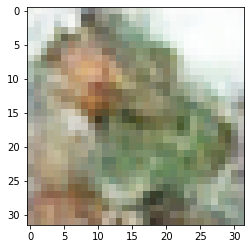

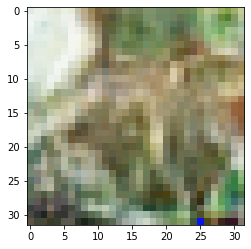

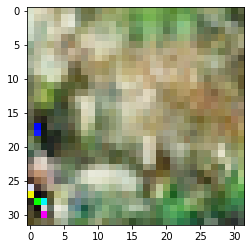

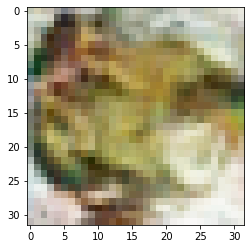

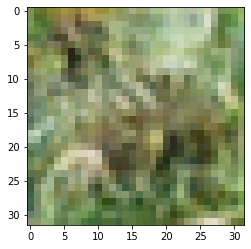

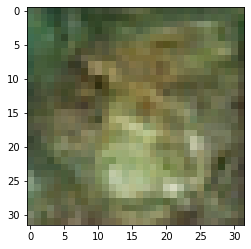

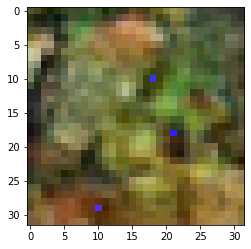

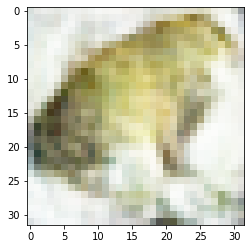

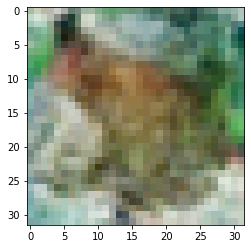

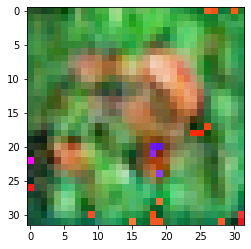

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# Muestreamos puntos aleatorios en el espacio latente
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Los decodificamos para imágenes falsas
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

Recuerda que son imágenes generadas aleatoriamente, pero que se parecen a imágenes de la clase Froggy (rana), aunque con algunos fallos pixelados.

Si te interesa profundizar más, puedes encontrar implementaciones de diferentes GANs en el repositorio de github [Keras-GAN
](https://github.com/eriklindernoren/Keras-GAN#gan)